# Mini-Projekt 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

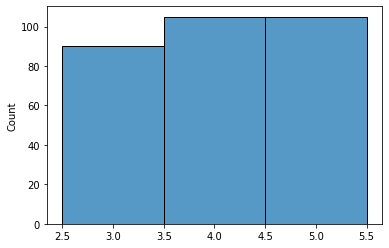

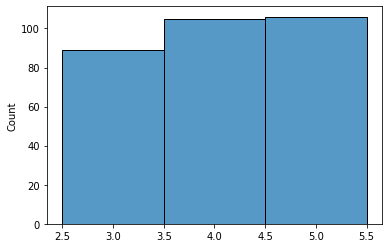

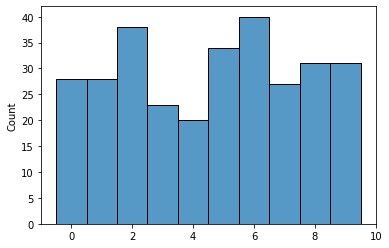

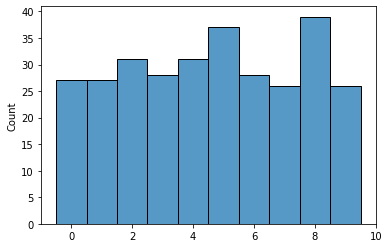

In [2]:
GRID_SIZE = 10
SAMPLE_NUM = 8000

np.random.seed(5)
dims = np.random.randint(3,6, size=(SAMPLE_NUM,2))
centers = np.random.randint(10, size=(SAMPLE_NUM, 2))
y, x = np.ogrid[:GRID_SIZE,:GRID_SIZE]

samples = []
for i in range(SAMPLE_NUM):
    width, height = dims[i]
    a, b = centers[i]
    rects = np.zeros((GRID_SIZE, GRID_SIZE))
    rects[((y < np.floor(height/2) + a) & (y > a - np.floor(height/2))) & ((x < np.floor(width/2) + b) & (x > b - np.floor(width/2)))] = 1
    rects = np.reshape(rects, GRID_SIZE**2)
    samples.append(rects)

sb.histplot(dims[:300,0], discrete=True) 
plt.show()
sb.histplot(dims[:300,1], discrete=True)
plt.show()
sb.histplot(centers[:300,0], discrete=True)
plt.show()
sb.histplot(centers[:300,1], discrete=True)
plt.show()

In [3]:
data_set = np.vstack(samples)

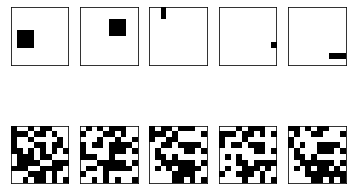

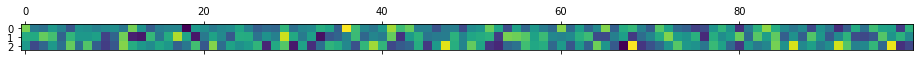

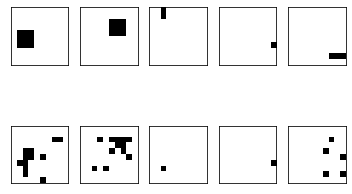

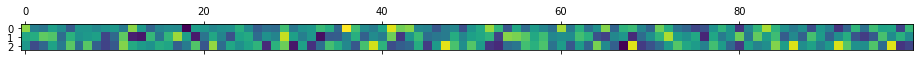

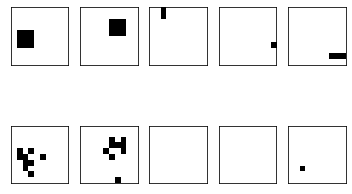

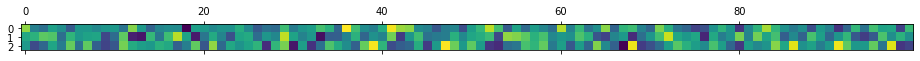

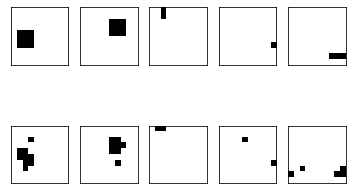

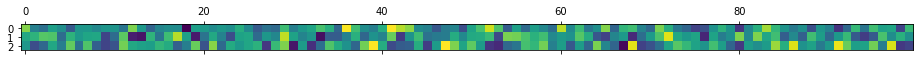

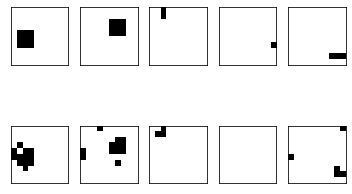

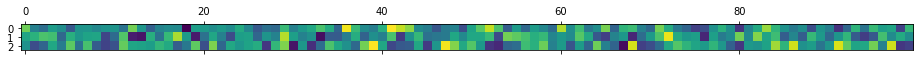

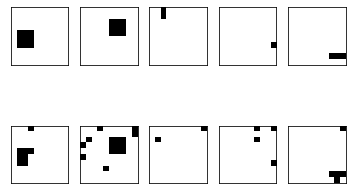

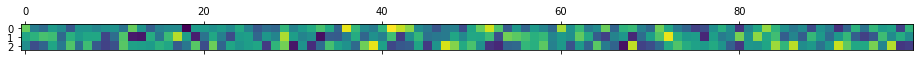

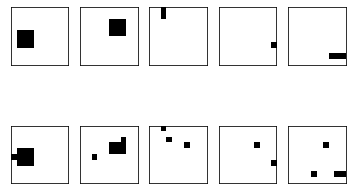

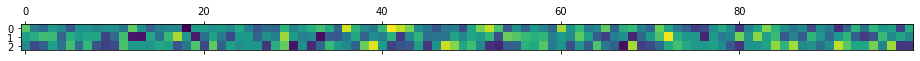

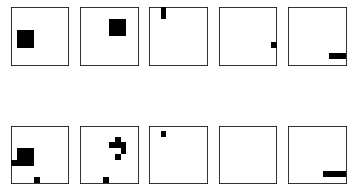

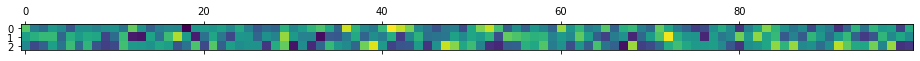

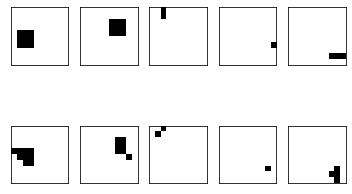

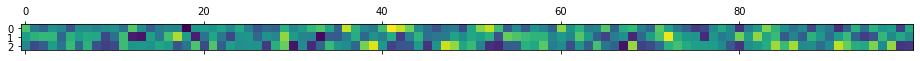

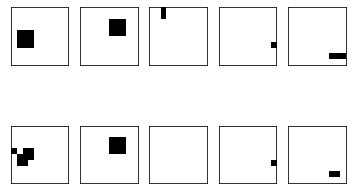

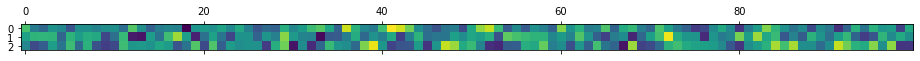

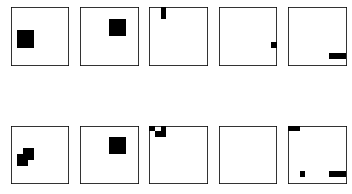

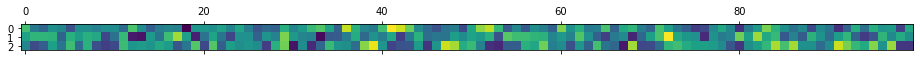

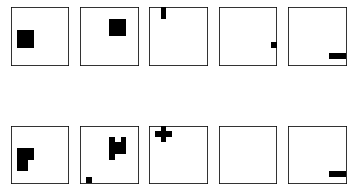

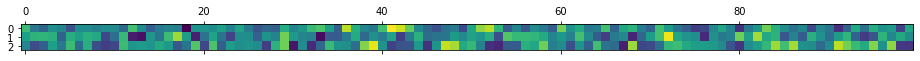

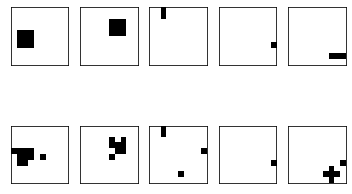

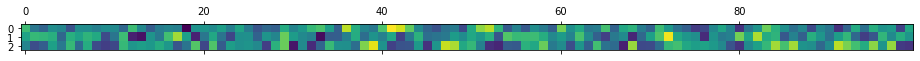

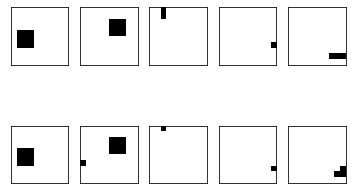

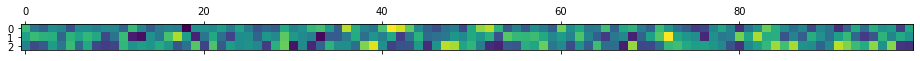

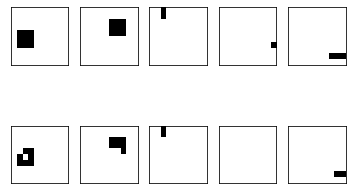

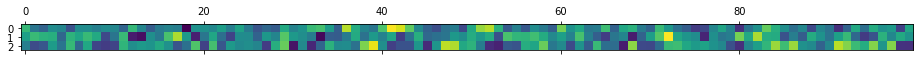

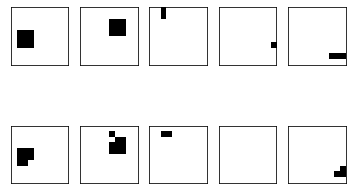

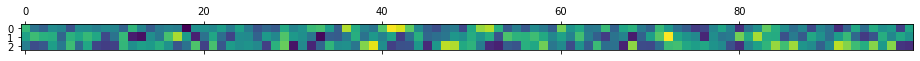

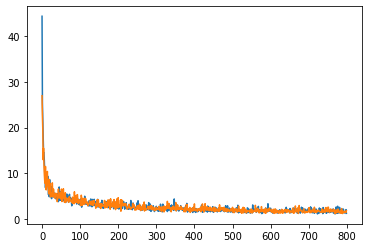

In [4]:
def boltzmann_step(v: np.array, b: np.array, w: np.ndarray):
    z = b + np.dot(v, w)
    
    # Übergangswahr'keit von h -> v
    
    sigmoid = np.exp(z)/(1 + np.exp(z))
    
    flipped = np.array(np.random.uniform(size=b.shape) < sigmoid, dtype=int)
    return flipped


def boltzmann_sequence(v, w, a, b):
    result = [v]
    h = boltzmann_step(result[-1], b, w)
    result.append(h)
    v_prime = boltzmann_step(h, a, np.transpose(w))
    result.append(v_prime)
    h_prime = boltzmann_step(v_prime, b, w)
    result.append(h_prime)
    return result

def calc_diffs(v, h, v_prime, h_prime):
    return(np.average(v,axis=0) - np.average(v_prime,axis=0) ,
        np.average(h,axis=0) - np.average(h_prime,axis=0) ,
        np.average(v[:,:,None] * h[:,None,:],axis=0)-
        np.average(v_prime[:,:,None]*h_prime[:,None,:],axis=0) )

def boltzmann_machine(data_set):
    progress = []
    
    VISIBLE_DIM = GRID_SIZE**2
    HIDDEN_DIM = GRID_SIZE**2//2 + 10
    TRAIN_STEPS = 800
    eta = .3
    
    # Initialisierung
    h = np.zeros(HIDDEN_DIM)
    w = np.random.randn(VISIBLE_DIM, HIDDEN_DIM)
    b = np.random.randn(HIDDEN_DIM)
    a = np.random.randn(VISIBLE_DIM)
    v, v_test = data_set[:5000], data_set[5000:]

    loss_test = []
    loss_train = []
    
    for step in range(TRAIN_STEPS):
        v, h, v_prime, h_prime =  boltzmann_sequence(v, w, a, b)
        da, db, dw = calc_diffs(v, h, v_prime, h_prime)
        a += eta * da
        b += eta * db
        w += eta * dw
        
        if step % 50 == 0:
            n = 5
            fig, axs = plt.subplots(2, n)

            for i in range(n):
            # display original
                subplt = axs[0, i]
                subplt.imshow(v[i].reshape(10,10), cmap='binary')
                subplt.get_xaxis().set_visible(False)
                subplt.get_yaxis().set_visible(False)

                # display reconstruction
                subplt = axs[1, i]
                subplt.imshow(v_prime[i].reshape(10,10), cmap='binary')
                subplt.get_xaxis().set_visible(False)
                subplt.get_yaxis().set_visible(False)
                
            plt.matshow(np.transpose(w)[:3])
            plt.show()
            progress.extend([np.copy(a), np.copy(b), np.copy(w)])
            
        loss_train.append(np.sum(np.abs(v-v_prime))/5000)
        v_test, h_test, v_p_test, h_p_test = boltzmann_sequence(v_test, w, a, b)
        loss_test.append(np.sum(np.abs(v_test-v_p_test))/3000)
    plt.plot(loss_train)
    plt.plot(loss_test)
    return a, b, w, progress    
    
a, b, w, progress = boltzmann_machine(data_set)

In [5]:
import seaborn as sb

def distribution(a, b, w, data_set):
    v, h, v_prime, h_prime = boltzmann_sequence(data_set, w, a, b)
    # Energie berechnen
    E_0 = []
    E = []
    
    for v_ in v:
        for h_ in h:
            E_0.append(np.exp(np.dot(v_, a) + np.dot(h_, b) + np.dot(np.transpose(v_), np.dot(w, h_))))
    for v_prime_ in v_prime:
        for h_prime_ in h_prime:
            E.append(np.exp(np.dot(v_prime_, a) + np.dot(h_prime_, b) + np.dot(np.transpose(v_prime_), np.dot(w, h_prime_))))
            
    Z=np.sum(E)
    Z_0=np.sum(E_0)
    
    p_arr = []
    p_0_arr = []
    for v_ in v:
        E = []
        for h_ in h:
             E.append(np.exp(np.dot(v_, a) + np.dot(h_, b) + np.dot(np.transpose(v_), np.dot(w, h_))))
        p = np.sum(E)/Z_0
        p_0_arr.append(p)
    
    for v_prime_ in v_prime:
        E = []
        for h_prime_ in h_prime:
             E.append(np.exp(np.dot(v_prime_, a) + np.dot(h_prime_, b) + np.dot(np.transpose(v_prime_), np.dot(w, h_prime_))))
        p = np.sum(E)/Z
        p_arr.append(p)
    
    return p_0_arr, p_arr 
    
    
cross_entropy_arr = [[] for l in range(16)]
for j in range(5):
    for i in range(0, 48, 3):
        print(i)
        p_0_arr, p_arr = distribution(*progress[i:i+3], data_set[:300])
        # Berechne Cross-entropy zwischen der ursprünglichen und modellierten Verteilung
        cross_entropy = 0
        for k in range(len(p_0_arr)):
            cross_entropy += p_0_arr[k] * np.log(p_arr[k])
        cross_entropy_arr[i//3].append(cross_entropy)
    print(f'Nach {j+1} Durchgängen:')
    print(cross_entropy_arr)

0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
Nach 1 Durchgängen:
[[-26.548624190378895], [-3.165084867335854], [-6.816474113098721], [-4.28453837506683], [-10.15118435034047], [-11.63276896686965], [-3.173443289962052], [-9.819342014924358], [-9.962819613569316], [-5.3678809525725075], [-6.342973175072166], [-6.097077455274928], [-11.620069064626277], [-5.534907540833976], [-5.056453809642422], [-4.675067771182813]]
0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
Nach 2 Durchgängen:
[[-26.548624190378895, -37.435943223080706], [-3.165084867335854, -11.323158507777675], [-6.816474113098721, -10.4187830917785], [-4.28453837506683, -5.81451135886082], [-10.15118435034047, -12.447859011366743], [-11.63276896686965, -7.177339341875377], [-3.173443289962052, -11.861001606733863], [-9.819342014924358, -5.4265141548509055], [-9.962819613569316, -7.481586840853698], [-5.3678809525725075, -4.96991773018771], [-6.342973175072166, -7.1432569086575946], [-6.097077455274928, -7.6496169740900175], [-11.62

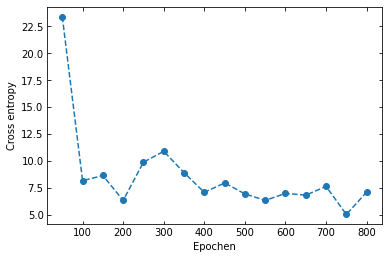

In [6]:
mean = [np.mean(cross_entropy_arr[i]) for i in range(16)]
epochs = np.linspace(50,800,16)

plt.scatter(epochs, np.abs(mean))
plt.plot(epochs, np.abs(mean), '--')
plt.tick_params('x', top=True, direction='in')
plt.tick_params('y', right=True, direction='in')
plt.xlabel('Epochen')
plt.ylabel('Cross entropy')
plt.show()